In [1]:
# Titanic Dataset: XGBoost vs LightGBM with Hyperparameter Tuning

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df = pd.read_csv("Titanic_train.csv")

In [3]:
# Drop irrelevant columns
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [4]:
# Impute missing values
imputer = SimpleImputer(strategy='median')
df['Age'] = imputer.fit_transform(df[['Age']])
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

<ipython-input-4-d40a149103e2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


In [5]:
# Encode categorical variables
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])

In [6]:
# Define features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

In [7]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Define hyperparameter grid for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}

In [9]:
# XGBoost model with tuning
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, cv=3, n_iter=10, scoring='accuracy', random_state=42)
xgb_search.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:22:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='accuracy')

In [10]:
# Best XGBoost model
xgb_best = xgb_search.best_estimator_
xgb_preds = xgb_best.predict(X_val)


In [11]:
# Metrics
print("XGBoost Classification Report:\n", classification_report(y_val, xgb_preds))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_val, xgb_preds))
print("XGBoost Accuracy:", accuracy_score(y_val, xgb_preds))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.84       105
           1       0.85      0.62      0.72        74

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.81      0.80      0.79       179

XGBoost Confusion Matrix:
 [[97  8]
 [28 46]]
XGBoost Accuracy: 0.7988826815642458


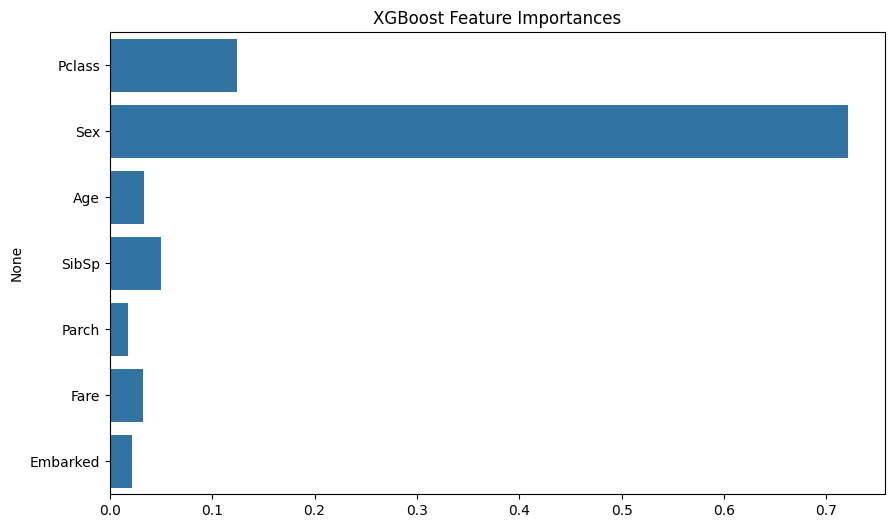

In [12]:
# Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_best.feature_importances_, y=X.columns)
plt.title("XGBoost Feature Importances")
plt.show()

In [13]:
# Define hyperparameter grid for LightGBM
lgbm_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 30, 40]
}

In [14]:
# LightGBM model with tuning
lgbm_model = LGBMClassifier()
lgbm_search = RandomizedSearchCV(lgbm_model, lgbm_params, cv=3, n_iter=10, scoring='accuracy', random_state=42)
lgbm_search.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 178, number of negative: 296
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 474, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.375527 -> initscore=-0.508576
[LightGBM] [Info] Start training from score -0.508576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [50, 100, 150],
                                        'num_leaves': [20, 30, 40]},
                   random_state=42, scoring='accuracy')

In [15]:
# Best LightGBM model
lgbm_best = lgbm_search.best_estimator_
lgbm_preds = lgbm_best.predict(X_val)

In [16]:
# Metrics
print("LightGBM Classification Report:\n", classification_report(y_val, lgbm_preds))
print("LightGBM Confusion Matrix:\n", confusion_matrix(y_val, lgbm_preds))
print("LightGBM Accuracy:", accuracy_score(y_val, lgbm_preds))

LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.85       105
           1       0.83      0.72      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

LightGBM Confusion Matrix:
 [[94 11]
 [21 53]]
LightGBM Accuracy: 0.8212290502793296


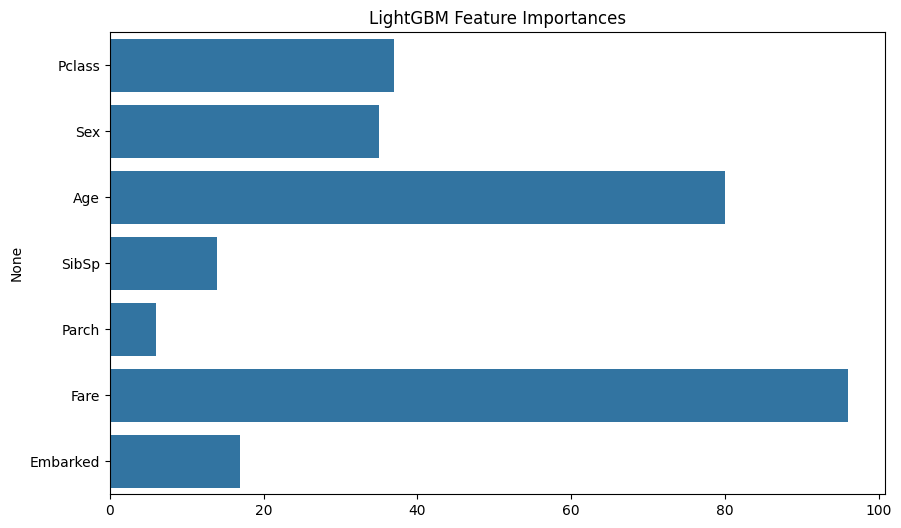

In [17]:
# Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x=lgbm_best.feature_importances_, y=X.columns)
plt.title("LightGBM Feature Importances")
plt.show()

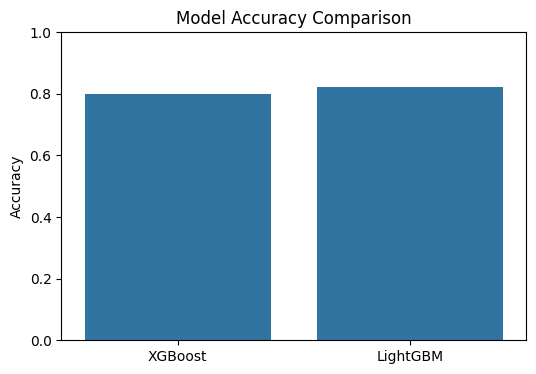

In [18]:
# Comparative Bar Plot
results = {
    "XGBoost": accuracy_score(y_val, xgb_preds),
    "LightGBM": accuracy_score(y_val, lgbm_preds)
}
plt.figure(figsize=(6, 4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()